In [1]:
# imports
import numpy
from matplotlib import pyplot, rcParams
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = '14'
colors = ['#5573a9', '#d4ba95', '#a27f47', '#020c0d']

### FMM

#### 1. Performance of our FMM code vs Yokota's benchmark of other major FMM software

<img src='./resources/FMMlibPerformance.png'>

This figure is from Dr. Yokota's paper: [An FMM Based on Dual Tree Traversal for Many-core Architecture](http://act.sagepub.com/content/7/3/301.full.pdf+html). The plot shows the timings of different FMM codes to solve a Laplace kernel where particles are randomly distributed in a cube. The parameters (a combination of $p$ and $\theta_{MAC}$) are chosen to achieve 3 significant digits of accuracy for the force. These benchmarks were tested on a hexa-core Xeon X5650 CPU.

We benchmark our FMM solver using a Laplace kernel with randomly distributed particles in a unit cube (same settings). We set $p=5$, $\theta_{MAC} = 0.5$, $n_{crit} = 125$ (optimal), and performed these benchmarks using different number of particles on our lab workstation with an Intel Core i7-5930K hexa-core processor. Using these parameters, we obtained 4 significant digits of accuracy in the Laplace force. The result is tabulated below, where the reported timing is the average of 3 identical runs.

| N | $t_{solve}$ (s) | l2-norm Err |
|---|:---:|:---:|:---:|
| $10^4$ | 0.1327 | 8.13e-04 |
| $10^5$ | 0.8683 | 6.52e-04 |
| $10^6$ | 7.4749 | 8.11e-04 |

Despite the fact that the hardwares are not the same (but both hexa-core CPUs), our FMM performance falls into the range of several major FMM codes, reported in Yokota's paper, showing that our FMM code gives a competitive performance. 

#### 2. search for optimal $n_{crit}$

We used a range of $n_{crit}$ (from 30 to 400) to find the optimal one which minimizes the execution time for the largest case where $N = 10^6, p=5, \theta_{MAC}=0.5$.

In [2]:
ncrit_set = numpy.append([30], numpy.linspace(50, 400, 8))
time_set = numpy.array((18.0106, 7.69836, 7.68442, 7.74045, 7.93905, 30.7653, 22.8208, 22.2847, 24.3553))

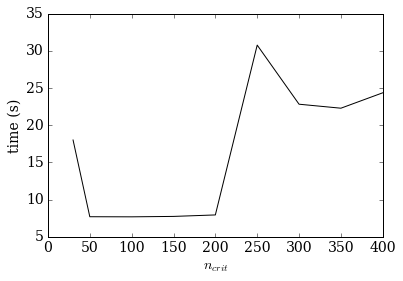

In [3]:
pyplot.plot(ncrit_set, time_set, 'k-')
pyplot.xlabel('$n_{crit}$')
pyplot.ylabel('time (s)');

From the plot, we can find that the optimal $n_{crit}$ lies in the range between 50 and 200. Again we ran with 16 values between 50 and 200, and found the timings are very close to each other (most of them are between 7.48s and 7.68s). The optimal case (7.48s) occurs at $n_{crit}=120$ and $n_{crit}=130$, so we used the middle value: 125 as the optimal $n_{crit}$.

### Laplace Equation

#### 1. Grid Convergence

We first studied grid convergence of our solver on a Laplace problem with unit potential and charge on the sphere. For each increasingly refined mesh, we measured the relative error of the potential evaluted at an exterior point with respect to the analytical solution. The reason to choose an exterior point is that if we monitor at some points (ex. collocation points) on the surface, as we refine the mesh, those surface points are moving. To avoid this spatial mismatch, we choose to evaluate the potential at a fixed point outside the sphere. **So the next question is where to choose this point?**

In addition, since we don't know how stringent the parameters (the order of expansion $p$, the number of Gauss quadrature points $K$, the solver's tolerance $\eta$) should be ahead of time, we have to start with a set of tight parameters (high $p$, high $K$, small $\eta$) to reveal the discretization error. These values are listed in the table below.

**tight parameters, fixed-p**:

| $N$ | 128-131072  |
|:---:|:---:|
| $K$ | 13 |
| $p$ | 20 |
| $\eta$ | 1e-10 |
| $n_{crit}$ | 400 |

We set $n_{crit}$ (the maximum number of particles in a leaf) to 400 since it gives a well-balanced P2P vs M2L for the cases without relaxation.

We compute the potentials at three exterior points: $(3,3,3)$, $(-7,2,-5)$, $(5, -3, -4)$ for different number of panels, and compare them to their analytical solutions. The aim of this test is to find whether different choices of observation point would give us the same order of grid convergence.

In [4]:
# grid convergence at various exterior points
# fixed-p, tight parameters
recur = numpy.arange(3, 9)
N = 2*4**recur

# exterior point a = (3, 3, 3)
e_ext_a = numpy.zeros((2, len(N)))
# 1st-kind
e_ext_a[0,:] = numpy.array([3.4071e-02, 8.9945e-03, 2.3178e-03, \
                            5.9768e-04, 1.5691e-04, 4.2748e-05])
# 2nd-kind
e_ext_a[1,:] = numpy.array([6.2776e-02, 1.6136e-02, 4.0271e-03, \
                            9.9279e-04, 2.4107e-04, 5.6753e-05])

# exterior point b = (-7, 2, -5)
e_ext_b = numpy.zeros((2, len(N)))
# 1st-kind
e_ext_b[0,:] = numpy.array([3.4061e-02, 8.9917e-03, 2.3170e-03, \
                            5.9747e-04, 1.5679e-04, 4.2738e-05])
# 2nd-kind
e_ext_b[1,:] = numpy.array([6.2771e-02, 1.6134e-02, 4.0267e-03, \
                            9.9271e-04, 2.4105e-04, 5.6752e-05])

# exterior point c = (5, -3, -4)
e_ext_c = numpy.zeros((2, len(N)))
# 1st-kind
e_ext_c[0,:] = numpy.array([3.4063e-02, 8.9922e-03, 2.3172e-03, \
                            5.9751e-04, 1.5681e-04, 4.2740e-05])
# 2nd-kind
e_ext_c[1,:] = numpy.array([6.2772e-02, 1.6135e-02, 4.0268e-03, \
                            9.9272e-04, 2.4105e-04, 5.6752e-05])

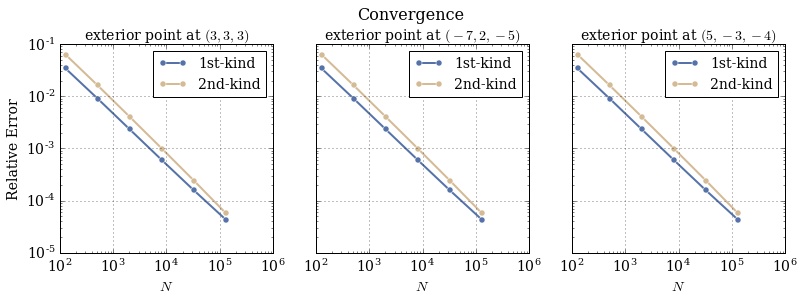

In [5]:
# plot
fig = pyplot.figure(figsize=(13,4), dpi=100)
fig.suptitle("Convergence", fontsize=16)
fig.subplots_adjust(top=0.85)

ax1 = fig.add_subplot(131)
ax1.loglog(N, e_ext_a[0,:], c=colors[0], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='1st-kind')
ax1.loglog(N, e_ext_a[1,:], c=colors[1], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='2nd-kind')
ax1.legend(loc='best', fontsize=14)
ax1.grid('on')
ax1.set_xlabel('$N$')
ax1.set_ylabel('Relative Error')
ax1.set_title('exterior point at $(3, 3, 3)$', fontsize=14)

ax2 = fig.add_subplot(132)
ax2.loglog(N, e_ext_b[0,:], c=colors[0], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='1st-kind')
ax2.loglog(N, e_ext_b[1,:], c=colors[1], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='2nd-kind')
ax2.legend(loc='best', fontsize=14)
ax2.grid('on')
ax2.set_xlabel('$N$')
ax2.set_yticklabels([])
ax2.set_title('exterior point at $(-7, 2, -5)$', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.loglog(N, e_ext_c[0,:], c=colors[0], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='1st-kind')
ax3.loglog(N, e_ext_c[1,:], c=colors[1], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='2nd-kind')
ax3.legend(loc='best', fontsize=14)
ax3.grid('on')
ax3.set_xlabel('$N$')
ax3.set_yticklabels([])
ax3.set_title('exterior point at $(5, -3, -4)$', fontsize=14);

We tested grid convergence with respect to potentials at different exterior points, showing that **the choice of this point doesn't affect the observed convergence rate of our BEM solver**. Thus, in the following speedup test, we only report the relative error of the potential at point $(3,3,3)$ for each case.

#### the observed order of convergence:

In [6]:
r = 4    # grid size ratio
print("1st-kind formulation")
print(numpy.round(numpy.log((e_ext_a[0,2]-e_ext_a[0,3])/
                 (e_ext_a[0,3]-e_ext_a[0,4]))/numpy.log(r), 2))
print("2nd-kind formulation")
print(numpy.round(numpy.log((e_ext_a[1,2]-e_ext_a[1,3])/
                 (e_ext_a[1,3]-e_ext_a[1,4]))/numpy.log(r),2))

1st-kind formulation
0.98
2nd-kind formulation
1.01


In the convergence study above, we used strict parameters ($K=13$, $p=20$, $\eta=10^{-10}$) since the discretization error should dominate other errors (even for the largest mesh). Now, we carefully slacken these parameters ($K, p, \eta$) one at a time until we see accuracy drops. After we determine the slackest $K,p,\eta$ (without affecting the accuracy), we choose the optimal $n_{crit}$s for both cases with and without relaxation. 

We tabulate these loose parameters below and use them in the following performance test to obtain a modest and unbiased speedup. 

#### loose parameters, fixed-p
| $N$ | 8192 | 32768 | 131072 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $K$ |  4 | 4 | 4 |
| $p$ | 8 | 10 | 10 |
| $\eta$ | 1e-6 | 1e-6 | 1e-6 |
| $n_{crit}$ (1st-kind)| 300 | 400 | 500 |
| $n_{crit}$ (2nd-kind)| 300 | 400 | 500 |

#### loose parameters, relaxed-p
| $N$ | 8192 | 32768 | 131072 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $K$ |  4 | 4 | 4 |
| $p_{init}$ | 8 | 10 | 10 |
| $\eta$ | 1e-6 | 1e-6 | 1e-6 |
| $n_{crit}$ (1st-kind)| 100 | 100 | 200 |
| $n_{crit}$ (2nd-kind)| 300 | 300 | 300 |

For three smaller test cases ($N=128, 512, 2048$), the problem size is too small (solving time is within 1 second) to show the benefit of relaxation, therefore, we will neither list the loose parameters for these cases, nor include them in the speedup test.

We repeat the convergence test by using the loosened parameters for both fixed-p and relaxed-p cases as the figure below. The relative errors from using loose parameters are very close to those from the tight parameter settings. So we are convinced that 1). our choice of slack parameters is reasonable and accurate and 2). our relaxation strategy on GMRES will not deteriorate the accuracy. We will use these slackened parameters in the future speedup test.

In [7]:
# 1st-kind
ef1_l = numpy.array([6.165e-04, 1.690e-04, 4.935e-05])
er1_l = numpy.array([6.128e-04, 1.703e-04, 5.055e-05])    # only for three larger grids
# 2nd-kind
ef2_l = numpy.array([9.739e-04, 2.290e-04, 5.014e-05])
er2_l = numpy.array([9.739e-04, 2.289e-04, 4.973e-05])

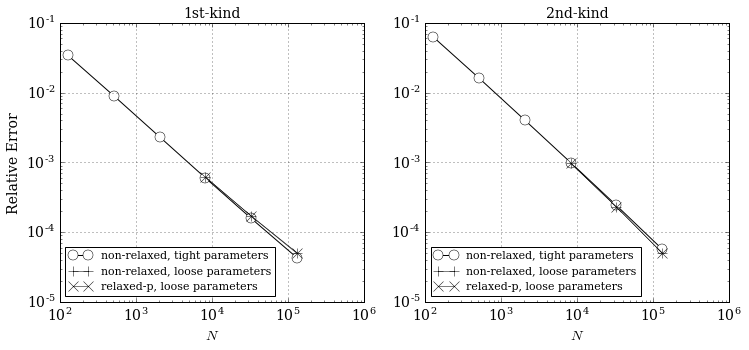

In [8]:
# plot convergence
fig = pyplot.figure(figsize=(12,5), dpi=100)

ax1 = fig.add_subplot(121)
ax1.loglog(N, e_ext_a[0,:], c='k', ls='-', lw=1.0, marker='o', \
           mfc='w', ms=10, label='non-relaxed, tight parameters')
# loose params
ax1.loglog(N[-3:], ef1_l, c='k', ls='-', lw=0.5, marker='+', \
           ms=10, label='non-relaxed, loose parameters')
ax1.loglog(N[-3:], er1_l, c='k', ls='-', lw=0.5, marker='x', \
           ms=10, label='relaxed-p, loose parameters')
ax1.set_xlabel('$N$', fontsize=14)
ax1.set_ylabel('Relative Error')
ax1.legend(loc=3, fontsize=11)
ax1.grid('on')
ax1.set_title('1st-kind', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.loglog(N, e_ext_a[1,:], c='k', ls='-', lw=1.0, marker='o', \
           mfc='w', ms=10, label='non-relaxed, tight parameters')
# loose params
ax2.loglog(N[-3:], ef2_l, c='k', ls='-', lw=0.5, marker='+', \
           ms=10, label='non-relaxed, loose parameters')
ax2.loglog(N[-3:], er2_l, c='k', ls='-', lw=0.5, marker='x', \
           ms=10, label='relaxed-p, loose parameters')
ax2.set_xlabel('$N$', fontsize=14)
ax2.legend(loc=3, fontsize=11)
ax2.grid('on')
ax2.set_title('2nd-kind', fontsize=14);

-------------

#### 2. How do we determine the loose paramters? Take $p$ as an example. Or how does $p$/$p_{initial}$ affect the solver's accuracy?

In this section, we will show how we determine the loose $p$ for each case. Here we take Laplace equation with Dirichlet boundary condition (1st-kind Fredholm integral equation) as an example. Suppose we fix $k$ at 4 and $tol$ at 1e-6, then we use a set of $p$ ranging from 3 to 15 (with a step of 3). For each $p$, we measure two quantities: 1). the l2 norm of the relative error of $\frac{\partial \Phi}{\partial n}$ at collocation points (these are the unknowns of the BEM system of linear equations) 2). the relative error of the potential at an exterior point (the quantity of interest, which is a integral quantity based on $\Phi$ s and $\frac{\partial \Phi}{\partial n}$ s at the collocation points on the surface). 

For each problem size $N$, we plot two relative errors against the changing $p$ in the figure below. As we can see, the accuracy of $\frac{\partial \Phi}{\partial n}$ at the collocation points (left figure) increases as we uses a higher $p$ for each problem size. In the smallest case $N=8192$, the the curve saturates at $p\approx9$; while in the medium one, it flattens at $p\approx12$. For the largest case ($N=131072$), the discretization error is so tiny that we can still improve the accuracy with a $p>15$. The figure on the right gives you the relative error of the potential at an exterior point $(3,3,3)$. Since the potential at $(3,3,3)$ is an integral quantity, the curve saturates faster than the left plot. The relative error of this integral quantity saturates at $p \approx 7$ for $N=8192$, and at $p \approx 9$ for $N = 32768, 131072$. Taking both into consideration, we set the loose $p$ to be $8, 10, 10$ respectively for the three cases (we have to use some eye-norm here). That is how we choose the loosen $p$ for Laplace equation.

Similarly, we used the same procedure to select the loose $K$ and $\eta$ for each case. After we fix $p,K, \eta$, we choose the optimal $n_{crit}$ for each case which minimizes the execution time.

In [9]:
# 1st-kind, ext: at the exterior point, bd: on the boundary
p_set = numpy.linspace(3, 15, 5)

e_ext_r6 = numpy.array([2.0252e-03, 5.9882e-04, 6.2378e-04, \
                        6.1648e-04, 6.1949e-04])
e_bd_r6  = numpy.array([7.404e-02, 7.759e-03, 1.943e-03, \
                        1.909e-03, 1.896e-03])
e_ext_r7 = numpy.array([1.3735e-03, 1.1347e-04, 1.7347e-04, \
                        1.6886e-04, 1.6808e-04])
e_bd_r7  = numpy.array([2.914e-01, 1.509e-02, 1.943e-03, \
                        7.638e-04, 7.500e-04])
e_ext_r8 = numpy.array([1.5832e-03, 6.8753e-06, 5.2404e-05, \
                        4.9622e-05, 4.8365e-05])
e_bd_r8  = numpy.array([7.834e-01, 4.536e-02, 4.423e-03, \
                        4.443e-04, 1.890e-04])

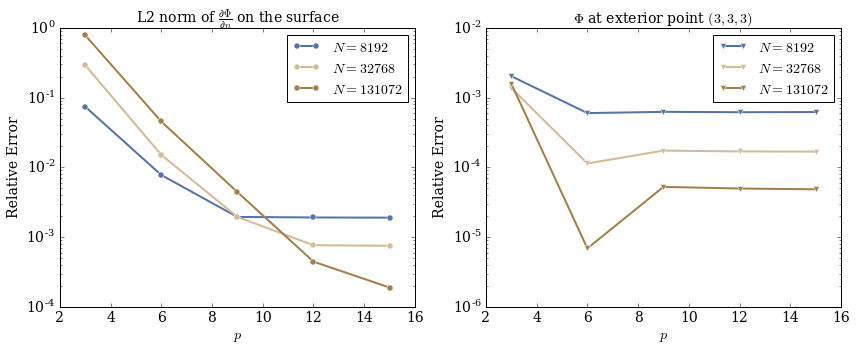

In [10]:
# plot
fig = pyplot.figure(figsize=(14,5), dpi=100)
ax1 = fig.add_subplot(121)
ax1.plot(p_set, e_bd_r6, c=colors[0], marker='o', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 8192$')
ax1.plot(p_set, e_bd_r7, c=colors[1], marker='o', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 32768$')
ax1.plot(p_set, e_bd_r8, c=colors[2], marker='o', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 131072$')
ax1.set_xlim(2, 16)
ax1.set_yscale('log')
ax1.set_xlabel('$p$')
ax1.set_ylabel('Relative Error')
#ax1.text(12, e_fixed_7[-2]*1.2, 'N = 32768', fontsize = 12)
#ax1.text(12, e_fixed_6[-2]*1.2, 'N = 8192', fontsize = 12)
ax1.legend(loc=1, fontsize=14)
ax1.set_title(r'L2 norm of $\frac{\partial \Phi}{\partial n}$ on the surface', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(p_set, e_ext_r6, c=colors[0], marker='v', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 8192$')
ax2.plot(p_set, e_ext_r7, c=colors[1], marker='v', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 32768$')
ax2.plot(p_set, e_ext_r8, c=colors[2], marker='v', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 131072$')
ax2.set_xlim(2, 16)
ax2.set_yscale('log')
ax2.set_xlabel('$p$')
ax2.set_ylabel('Relative Error')
ax2.legend(loc=1, fontsize=14)
ax2.set_title('$\Phi$ at exterior point $(3,3,3)$', fontsize=14);

#### 3. Residual vs Iterations plot

- problem size: $N = 32,768$
- using loose parameters: $k = 4$, $tol = 10^{-6}$, $n_{crit}=100$ and two different $p$ s: $p_{initial} = \{8 ,10 \}$

In this test, we want to show that how the required-$p$ decreases as iteration proceed. 

We use $p=10$ and $p=8$ separately, other parameters ($K$, $\eta$) are chosen from loose parameter set, and $n_{crit}=100$ is optimal. 

In [11]:
result_p8 = numpy.genfromtxt('./resources/LaplaceResidualP_p8', dtype=None)
result_p10 = numpy.genfromtxt('./resources/LaplaceResidualP_p10', dtype=None)
r_p8 = numpy.empty(result_p8.shape[0])
p_p8 = numpy.empty(result_p8.shape[0])
r_p10 = numpy.empty(result_p10.shape[0])
p_p10 = numpy.empty(result_p10.shape[0])
# parse residual and required-p
for i in range(result_p8.shape[0]-1):
    r_p8[i] = float(result_p8[i, 3].decode('UTF-8')[:-1])
    p_p8[i] = float(result_p8[i, -1].decode('UTF-8'))
# last iteration
r_p8[-1] = float(result_p8[-1, 2].decode('UTF-8')[:-1])
p_p8[-1] = 1

# parse residual and required-p
for i in range(result_p10.shape[0]-1):
    r_p10[i] = float(result_p10[i, 3].decode('UTF-8')[:-1])
    p_p10[i] = float(result_p10[i, -1].decode('UTF-8'))
# last iteration
r_p10[-1] = float(result_p10[-1, 2].decode('UTF-8')[:-1])
p_p10[-1] = 1

In [12]:
# iteration number
ind1 = numpy.arange(len(r_p8), dtype=int) + 1
ind2 = numpy.arange(len(r_p10), dtype=int) + 1

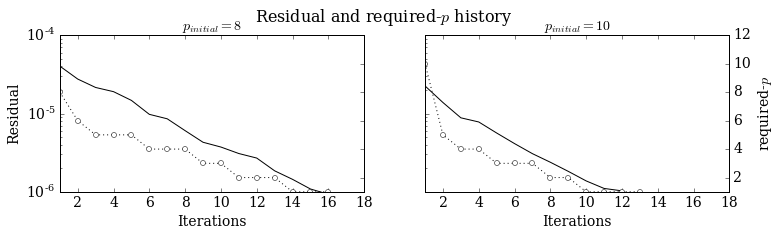

In [13]:
# plot
fig = pyplot.figure(figsize=(12,3), dpi=100)
fig.suptitle("Residual and required-$p$ history", fontsize=16)
fig.subplots_adjust(top=0.85)
# left plot
ax1 = fig.add_subplot(121)
# plot residual
ax1.semilogy(ind1,r_p8,color='k',marker='', ls='-', mfc='w', ms=5)
# plot required-p
ax2 = ax1.twinx()
ax2.plot(ind1,p_p8,color='k',marker='o',ls=':', mfc='w', ms=5)
# axis labels
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Iterations', fontsize=14)
ax1.set_ylim(1e-6, 1e-4)
ax2.set_ylim(1,12)
ax2.set_xlim(1,18)
pyplot.setp(ax2.get_yticklabels(), visible=False)
ax1.set_title('$p_{initial} = 8$', fontsize=14)

# right plot
ax3 = fig.add_subplot(122)
# plot residual
ax3.semilogy(ind2,r_p10,color='k',marker='', ls='-', mfc='w', ms=5)
# plot required-p
ax4 = ax3.twinx()
ax4.plot(ind2,p_p10,color='k',marker='o',ls=':', mfc='w', ms=5)
# axis labels
ax3.set_xlabel('Iterations', fontsize=14)
ax3.set_ylim(1e-6, 1e-4)
ax3.set_yticklabels([])
ax4.set_ylabel('required-$p$', fontsize=14)
ax4.set_xlim(1,18)
ax4.set_ylim(1,12)
ax3.set_title('$p_{initial} = 10$', fontsize=14);

The figure above shows how residual and required-p change as iterations proceeds. As the residual gets smaller, the value of $p$ needed to maintain convergence of the solver drops, and a low-$p$ of just $2$ is sufficient by the eleventh iteration for $p_{initial = 8}$ and by the eighth iteration for $p_{initial} = 10$.

#### 4. Speedup Test

We use the loose parameters ($K, p, \eta$) listed above and the optimal $n_{crit}$ to benchmark our FMM-BEM solver with and without relaxation on a Laplace problem. Time reported below is the average solving time (wall time) of three identical runs. We also report the number of iterations and relative error for each case to verify that relaxation would not degrade the accuracy.

#### 1st-kind
|   | fixed-$p$ | | | | relaxed-$p$ | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | speedup |
| 8192   | 300 | 3.14 | 11 | 6.165e-04 | 100 | 2.07 | 12 | 6.128e-04 | 1.52 |
| 32768  | 400 | 19.84 | 11 | 1.690e-04 | 100 | 11.48 | 13 | 1.703e-04 | 1.73 |
| 131072 | 500 | 97.37 | 13 | 4.935e-05 | 200 | 43.06 | 14 | 5.055e-05 | 2.26 |

#### 2nd-kind
|   | fixed-$p$ | | | | relaxed-$p$ | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | speedup |
| 8192   | 300 | 1.19 | 2 | 9.739e-04 | 300 | 1.00 | 2 | 9.739e-04 | 1.19 |
| 32768  | 400 | 7.10 | 2 | 2.290e-04 | 300 | 5.49 | 2 | 2.289e-04 | 1.29 |
| 131072 | 500 | 27.49 | 2 | 5.014e-05 | 300 | 22.49 | 2 | 4.973e-05 | 1.22 |

-------------

### Stokes Flow on a Sphere

#### 1. Grid Convergence

Similar to the previous section, we first used a set of tight parameters for grid convergence test, where we compared the calculated drag force with its analytical solution. Because of the memory restriction, we cannot use a near-optimal `ncrit=400` for the largest mesh. Therefore, we used the largest possible `ncrit=150` for that case.

#### tight parameters, fixed-p:

| $N$ | 128-32768 | 131072 |
|:---:|:---:|:---:|
| $K$ | 13 | 13 |
| `ncrit` | 400 | 150 |
| $p$ | 20 | 20 |
| $\eta$ | 1e-10 | 1e-10 |


In [14]:
# fixed-p, tight parameters
ef1 = numpy.array([1.87492e-01, 9.39450e-02, 4.63921e-02,
                   2.29365e-02, 1.13824e-02, 5.78213e-03])

Using the 3 points in the middle, the observed order of convergence for Stokes equation is 0.51, matching the expect rate of $\mathcal{O}(1/\sqrt N)$.

In [15]:
r = 4    # grid size ratio
print("1st-kind formulation")
print(numpy.round(numpy.log((ef1[2]-ef1[3])/
                 (ef1[3]-ef1[4]))/numpy.log(r), 2))

1st-kind formulation
0.51


As we did before, we gradually slacken $K, p, \eta$ until the relative error goes up. $n_{crit}$ is chosen to minimize the solving time.

**loose parameters, fixed-p:**

| $N$ | 8192 | 32768 | 131072 |
|:---:|:---:|:---:|:---:|
| $K$ | 4 | 4 | 4 |
|`ncrit`| 300 | 400 | 150 |
| $p$ | 12 | 12 | 14 |
| $\eta$ | 1e-5 | 1e-5 | 1e-5 |

**loose parameters, relaxed-p:**

| $N$ | 8192 | 32768 | 131072 |
|:---:|:---:|:---:|:---:|
| $K$ | 4 | 4 | 4 |
|`ncrit`| 100 | 60 | 80 |
| $p_{init}$ | 12 | 12 | 14 |
| $p_{min}$ | 4 | 3 | 4 |
| $\eta$ | 1e-5 | 1e-5 | 5e-6 | 


In the loose parameter setting for the relaxed-p cases, we found that we have to enforce a minimum $p$ to preserve the accuracy of the result. So We first determined $p_{initial}$, $p_{min}$ and $\eta$ required for each case, then found the optimal $n_{crit}$.

In [16]:
# only for three larger grids
ef1_l = numpy.array([2.27493e-02, 1.11135e-02, 5.78213e-03])
er1_l = numpy.array([2.324e-02, 1.110e-02, 6.548e-03])

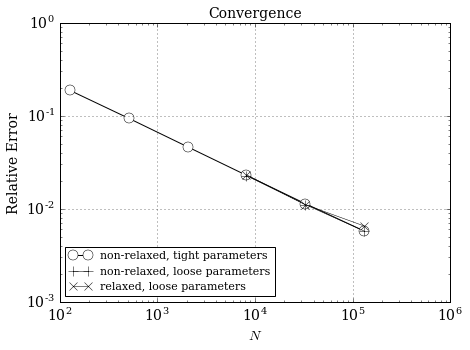

In [17]:
# plot convergence
fig = pyplot.figure(figsize=(7,5), dpi=100)

ax1 = fig.add_subplot(111)
ax1.loglog(N, ef1, c='k', ls='-', lw=1.0, marker='o', \
           mfc='w', ms=10, label='non-relaxed, tight parameters')

# loose params
ax1.loglog(N[-3:], ef1_l, c='k', ls='-', lw=0.5, marker='+', \
           ms=10, label='non-relaxed, loose parameters')
ax1.loglog(N[-3:], er1_l, c='k', ls='-', lw=0.5, marker='x', \
           ms=8, label='relaxed, loose parameters')
ax1.set_xlabel('$N$', fontsize=14)
ax1.set_ylabel('Relative Error')
ax1.legend(loc=3, fontsize=11)
ax1.grid('on')
ax1.set_title('Convergence', fontsize=14);

We repeated the convergence test with the loose parameters, as the above figure shows.  The result convinces us that our choice of loose parameters is proper and the relaxation will not deterioate accuracy.

#### 2. Speedup Test

We use the loose parameters ($K, p, p_{min}, \eta$) listed above and the optimal $n_{crit}$ to benchmark our FMM-BEM solver with and without relaxation on a Stokes problem. Time reported below is the average solving time (wall time) of three identical runs. We also report the number of iterations and relative error for each case to verify that relaxation would not degrade the accuracy.


|   | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | pmin | speedup |
| 8192 | 300 | 82.57 | 27 | 2.275e-02 | 100 | 30.56 | 29 | 2.324e-02 | 4 | 2.70 |
| 32768  | 400 | 370.18 | 27 | 1.111e-02 | 60 | 111.93 | 30 | 1.110e-02 | 3 | 3.31 |
| 131072 | 150 | 3058.93 | 24 | 5.782e-03 | 80 | 682.14 | 34 | 6.548e-03 | 4 | 4.48 |

#### 3. Time Breakdown

In this section, we demonstrate the load balance between near-field and far-field interaction in the relaxed GMRES solver. The case we choose is the optimal case with 32768 panels (corresponding the second case in the table above).

In [18]:
result = numpy.genfromtxt('./resources/StokesSphereBreakdown', dtype=None)
P2P = numpy.empty(result.shape[0])
M2L = numpy.empty(result.shape[0])

In [19]:
for i in range(result.shape[0]):
    P2P[i] = float(result[i, 1].decode('UTF-8')[:-2])
    M2L[i] = float(result[i, -1].decode('UTF-8')[:-1])
P2P_sum = numpy.sum(P2P)
M2L_sum = numpy.sum(M2L)

In [20]:
print("P2P total time:", P2P_sum)
print("M2L total time:", M2L_sum)

P2P total time: 61.415
M2L total time: 47.582


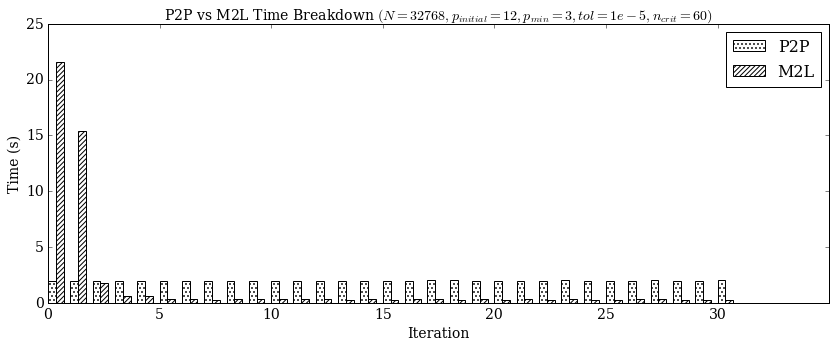

In [21]:
# plot
fig = pyplot.figure(figsize=(14,5), dpi=80)
ax = fig.add_subplot(111)

ind = numpy.arange(len(P2P))
width = 0.35

# plot bars
bar1 = ax.bar(ind, P2P, width, fill=False, edgecolor='k', hatch='.'*3, linewidth=1)
bar2 = ax.bar(ind+width, M2L, width, fill=False, edgecolor='k', hatch='/'*5, linewidth=1)

# axis labels
ax.set_ylabel('Time (s)', fontsize=14)
ax.set_xlabel('Iteration', fontsize=14)
pyplot.xticks(numpy.arange(min(ind), max(ind)+1, 5.0))
ax.legend( (bar1[0], bar2[0]), ('P2P', 'M2L'), loc=1, fontsize=16)
ax.set_title('P2P vs M2L Time Breakdown $(N = 32768, p_{initial} = 12, \
              p_{min} = 3, tol = 1e-5, n_{crit}=60)$', fontsize=14);

Because most of the iterations are spent computing at the low values of $p$, we need to start with a bloated far field. The bar plot shows the breakdown of time spent in the P2P and M2L kernels for each iteration: although the first iteration is unbalanced, with far field taking about 10 times as much cpu time as near field, later iterations are close to balanced and the total time to solution is optimal: P2P takes 63s in total, while M2L costs 47s.

----------------------

### Stokes Flow on Red Blood Cells

#### 1. Grid Convergence of a single red blood cell

While there is no analytical solution for the Stokes flow around a red blood cell, we use Richardson extrapolation to estimate the analytical solution in this convergence test. For the same reason of memory restriction, we cannot use near-optimal $n_{crit} = 400$ for the largest case. We used $n_{crit} = 150$ which gives the best available performance running the largest case on our workstation.

**tight parameters, fixed-p:** 

| $N$ | 128-32768 | 131072 |
|:---:|:---:|:---:|
| $K$ | 13 | 13 |
| `ncrit` | 400 | 150 |
| $p$ | 20 | 20 |
| $\eta$ | 1e-10 | 1e-10 |

Like what we did before, we also wish to select a slack set of parameters for convergence test and benchmarking. Because the problem lacks an analytical solution and later we will test on multiple combinations of different number of cells and different number of panels per cell, it is cumbersome to search for the loose parameters case by case. Instead, based on our choice for the Stokes flow on a sphere, we chose a safe and universal set of loose parameters— $p = 14, p_{min} = 3, K = 4, \eta = 1e−5$—for the application to red blood cells, then we found the optimal $n_{crit}$ for each case with and without relaxation. These loose parameters are listed below.

**loose parameters, fixed-p**:

| $N$ | 2048 | 8192 | 32768 | 131072 |
|:---:|:---:|:---:|:---:|:---:|
| $K$ | 4 | 4 | 4 | 4 |
|`ncrit`| 400 | 400 | 400 | 150 |
| $p$ | 14 | 14 | 14 | 14 |
| $\eta$ | 1e-5 | 1e-5 | 1e-5 | 1e-5 |

**loose parameters, relaxed-p:**

| N | 2048 | 8192 | 32768 | 131072 |
|:---:|:---:|:---:|:---:|:---:|
| $K$ | 4 | 4 | 4 | 4 |
|`ncrit`| 130 | 140 | 120 | 100 |
| $p_{init}$ | 14 | 14 | 14 | 14 |
| $p_{min}$ | 3 | 3 | 3 | 3 |
| $\eta$ | 1e-5 | 1e-5 | 1e-5 | 1e-5 |


In [22]:
f1 = - 0.05705    # 512  panels/cell
f2 = - 0.07032    # 2048 panels/cell
f3 = - 0.07663    # 8192 panels/cell
f4 = - 0.07988    # 32768 panels/cell
f5 = - 0.08141    # 131072 panels/cell
# Richardson Extrapolation
f_bar = (f1*f3 - f2**2) / (f1 - 2*f2 + f3)

In [23]:
f = numpy.array([f1, f2, f3, f4, f5])
err_rel = numpy.abs((f - f_bar)/f_bar)

# fixed-p, loose params
f_f = numpy.array([-0.07033, -0.07678, -0.07989, -0.08141])
e_f = numpy.abs((f_f - f_bar)/f_bar)
# relax-p, loose params
f_r = numpy.array([-0.07010, -0.07780, -0.07977, -0.08149])
e_r = numpy.abs((f_r - f_bar)/f_bar)

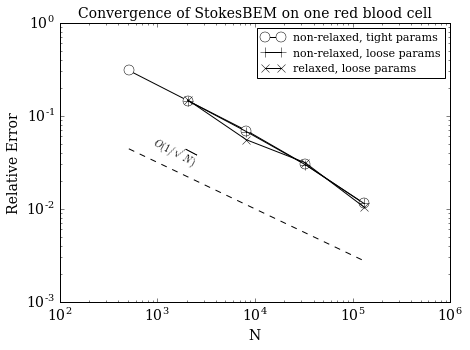

In [24]:
# set up data
N = numpy.array([512, 2048, 8192, 32768, 131072])
line_sqrtN = 1 / numpy.sqrt(N)

# set up plot
fig = pyplot.figure(figsize=(7,5), dpi=100)
ax = fig.add_subplot(111)

# plot log-log
ax.loglog(N,err_rel,c='k',marker='o', ls='-', mfc='w',\
          ms=10, label='non-relaxed, tight params')
ax.loglog(N[1:], e_f, c='k', marker='+', ls='-', ms=10, \
          label='non-relaxed, loose params')
ax.loglog(N[1:], e_r, c='k', marker='x', ls='-', ms=8, \
          label='relaxed, loose params')
ax.loglog(N,line_sqrtN,c='k',ls='--', mfc='w', ms=10)
ax.legend(loc='best', fontsize=11)

loc = (3*N[0]+N[1])/4
# text on plot: 1/sqrt(N)
tex_loc = numpy.array((loc,N[0]*err_rel[0]/loc))
ax.text(tex_loc[0], tex_loc[1]/3.5,r'$O(1/\sqrt{N})$',fontsize=10,rotation=-28, rotation_mode='anchor')
# axis labels
ax.set_ylabel('Relative Error', fontsize=14)
ax.set_xlabel('N', fontsize=14)
ax.set_title('Convergence of StokesBEM on one red blood cell', fontsize=14);

We used the test with tight parameters to calculate the observed order of convergence, and used the loose set in the future speedup test to measure an unbiased speedup. The figure above shows that the result from using loose parameters matches well with those from using tight parameters.

#### 2. Speedup Test

We use loose parameters with optimal $n_{crit}$ to measure the speedup. Due to the lack of analytical solution, we report the calculated drag force $f_x$ for each run.

**single red blood cell**

|   | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 2048 | 400 | 33.64 | 35 | -0.07033 | 130 | 11.21 | 37 | -0.07010 | 3 | 3.00 |
| 8192 | 400 | 183.73 | 39 | -0.07678 | 140 | 64.92 | 41 | -0.07780 | 3 | 2.83 |
| 32768 | 400 | 809.90 | 35 | -0.07989 | 120 | 253.90 | 39 | -0.07977 | 3 | 3.19 |
| 131072  | 150 | 4407.47 | 31 | -0.08141 | 100 | 980.65 | 35 | -0.08149 | 3 | 4.49 |

**2048 panels/cell** 

|   | | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_{panels}$ | $N_{cells}$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 2048 | 1 | 400 | 33.64 | 35 | -0.07033 | 130 | 11.21 | 37 | -0.07010 | 3 | 3.00 |
| 8192 | 4 | 400 | 204.43 | 51 | -0.19825 | 140 | 87.34 | 52 | -0.19765 | 3 | 2.34 |
| 32768 | 16 | 400 | 1128.50 | 67 | -0.67816 | 100 | 466.12 | 70 | -0.67270 | 3 | 2.42 |
| 131072  | 64 | 150 | 6186.23 | 76 | -2.41785 | 120 | 1953.23 | 79 | -2.41026 | 3 | 3.17 |

**8192 panels/cell** 

|   |  | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_{panels}$ | $N_{cells}$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 8192 | 1 | 400 | 183.73 | 39 | -0.07678 | 140 | 64.92 | 41 | -0.07780 | 3 | 2.83 |
| 32768 | 4 | 400 | 1300.30 | 54 | -0.21589 | 120 | 423.83 | 55 | -0.21703 | 3 | 3.07 |
| 131072  | 16 | 150 | 8837.73 | 67 | -0.73883 | 100 | 2097.87 | 68 | -0.73841 | 4 | 4.21 |

**32768 panels/cell** 

|   |  | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_{panels}$ | $N_{cells}$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 32768 | 1 | 400 | 809.90 | 35 | -0.07989 | 120 | 253.90 | 39 | -0.07977 | 3 | 3.19 |
| 131072  | 4 | 150 | 6171.47 | 49 | -0.22452 | 120 | 1599.33 | 51 | -0.22450 | 3 | 3.86 |

-------------